In [41]:
import tensorflow as tf
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as skmse
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

In [42]:
# cv2 can't directly display image in 'jupyter' IDE. Hence, this function to bypass the same by using cv2 and matplotlib.
def jup_imageshow(path):
    image_path = path # Read the image path
    image = cv2.imread(image_path) # Read the image
    if image is None:
        print("wrong credentials for the image path")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # change format from cv2 to matplotlib 
        #plt.figure(figsize=(8,6))
        plt.imshow(image_rgb)
        plt.title("Loaded Image")
        plt.axis('off')  # Hide axis
        plt.show()

In [43]:
# jup_imageshow(r"D:\preetam\AIML_Data\Eye detection\Dataset\train\images\i_1_jpg.rf.9ab2cf6915e1be9a55d8a9c560d323d6.jpg")

In [44]:
# funtion to return, name of folders/name of files/number of folders/number of files in a given location in my computer.
def filfol(folder_path,choice):
    items=os.listdir(folder_path)
    # Separate files and folders
    files=[f for f in items if os.path.isfile(os.path.join(folder_path, f))]
    folders=[f for f in items if os.path.isdir(os.path.join(folder_path, f))]
    if choice=="folder": # name of  folders
        return folders
    elif choice=="file": # name of files
        return files
    elif choice=="folder_n": # number of folders
        return len(folders)
    elif choice=="file_n": # number of files
        return len(files)
    else:
        print("wrong input choice")

In [45]:
f_path="D:/preetam/AIML_Data/celebrity/Celebrity Faces Dataset" # main dataset folder path
#print(filfol(f_path,"folder"))
#print("Number of folders=", filfol(f_path,"folder_n"))

In [46]:
y_index=np.arange(17)
y_dict=dict(zip(filfol(f_path,"folder"),y_index))
#print(y_dict["Brad Pitt"])

In [47]:
x=[]
y_label=[]
y=[]
hmax=0 # max pixels along heigt axis
wmax=0 # max pixels along width axis
total_files=0
for f in filfol(f_path,"folder"):
    for fi in filfol(f_path+"/"+f,"file"):
        img_path = os.path.join(f_path+"/"+f, fi)
        img=cv2.imread(img_path)
        img=cv2.resize(img,(100,100)) # resizing all images into similar dimension
        x.append(img)
        y_label.append(f)
        y.append(y_dict[f])
        if img.shape[:2][0]>hmax:
            hmax=img.shape[:2][0]
        if img.shape[:2][1]>wmax:
            wmax=img.shape[:2][0]
    #print(filfol(f_path+"/"+f,"file_n"))
    #total_files=total_files+filfol(f_path+"/"+f,"file_n")
#print(total_files)

In [48]:
x=np.array(x)
y=np.array(y)

In [49]:
# print an image
'''plt.rcParams["figure.figsize"] = (4, 4)
plt.imshow(cv2.cvtColor(x[100], cv2.COLOR_BGR2RGB))
plt.show()'''

'plt.rcParams["figure.figsize"] = (4, 4)\nplt.imshow(cv2.cvtColor(x[100], cv2.COLOR_BGR2RGB))\nplt.show()'

In [50]:
# Train/test dataset split
x=x/255
xtrain, xtest, ytrain, ytest=train_test_split(x,y,test_size=0.2, shuffle=True, random_state=42)

In [51]:
    # Data augmentation pipeline #

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),                # Mirror faces left/right
    #tf.keras.layers.RandomRotation(0.02),                    # ~ ±7.2° rotation
    tf.keras.layers.RandomTranslation(0.1, 0.1),             # Shift up to 10% in x/y
    tf.keras.layers.RandomZoom(0.10),                         # Zoom in/out by 10%
    #tf.keras.layers.RandomBrightness(factor=0.1),            # Adjust brightness ±10%
    tf.keras.layers.RandomContrast(factor=0.1),              # Adjust contrast ±10%
    tf.keras.layers.RandomCrop(height=90, width=90),         # Slight cropping
])

In [52]:
# CNN Layer description
cnn=tf.keras.models.Sequential([
    # CNN
    data_augmentation,
    #tf.keras.layers.InputLayer(shape=(100, 100, 3)),

    #tf.keras.layers.ZeroPadding2D(padding=1),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    #tf.keras.layers.ZeroPadding2D(padding=1),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    #tf.keras.layers.ZeroPadding2D(padding=1),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    #tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    # Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(17, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
])

In [53]:
# Compile the model
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:

# ---------------------------
# Callbacks
# ---------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=5,
    min_lr=1e-6
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_cnn_model.keras',  # saved model filename
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [55]:
# Training the model
history = cnn.fit(
    xtrain, ytrain,
    validation_data=(xtest, ytest),
    epochs=100,
    batch_size=36,
    callbacks=[early_stop, lr_schedule, checkpoint]
)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.0659 - loss: 9.0815    
Epoch 1: val_loss improved from inf to 7.14171, saving model to best_cnn_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 400ms/step - accuracy: 0.0661 - loss: 9.0564 - val_accuracy: 0.0472 - val_loss: 7.1417 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.0927 - loss: 6.5690 
Epoch 2: val_loss improved from 7.14171 to 6.19189, saving model to best_cnn_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 374ms/step - accuracy: 0.0928 - loss: 6.5610 - val_accuracy: 0.0583 - val_loss: 6.1919 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.1270 - loss: 5.3488 
Epoch 3: val_loss improved from 6.19189 to 5.37138, saving model to best_cnn_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 378ms/step - accuracy: 0.1267 - loss: 5.3436 - val_accuracy: 0.0333 - val_loss: 5.3714 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 37

In [56]:
# Predict
ypred_c = cnn.predict(xtest)
cnn.evaluate(xtest,ytest)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6756 - loss: 1.3583 


[1.3606525659561157, 0.6777777671813965]

In [57]:
from sklearn.metrics import classification_report
print(classification_report(ytest, np.argmax(ypred_c, axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.47      0.55        17
           1       0.45      0.87      0.59        15
           2       0.74      0.67      0.70        21
           3       0.65      0.58      0.61        26
           4       0.58      0.61      0.60        23
           5       0.76      0.64      0.70        25
           6       0.54      0.72      0.62        18
           7       0.75      0.63      0.69        19
           8       0.76      0.89      0.82        18
           9       0.57      0.44      0.50        18
          10       0.86      0.71      0.77        17
          11       0.61      0.73      0.67        15
          12       0.71      0.68      0.70        22
          13       0.75      0.83      0.78        46
          14       0.92      0.58      0.71        19
          15       0.71      0.67      0.69        15
          16       0.67      0.69      0.68        26

    accuracy              

In [58]:
cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (36, 90, 90, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (36, 90, 90, 32)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (36, 90, 90, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (36, 90, 90, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (36, 45, 45, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (36, 45, 45, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (36, 45, 45, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (36, 45, 45, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (36, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (36, 22, 22, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (36, 22, 22, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (36, 22, 22, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (36, 11, 11, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (36, 11, 11, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (36, 11, 11, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (36, 5, 5, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (36, 6400)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (36, 128)              │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (36, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (36, 17)               │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,933 (16.08 MB)

 Trainable params: 1,404,657 (5.36 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2,809,316 (10.72 MB)

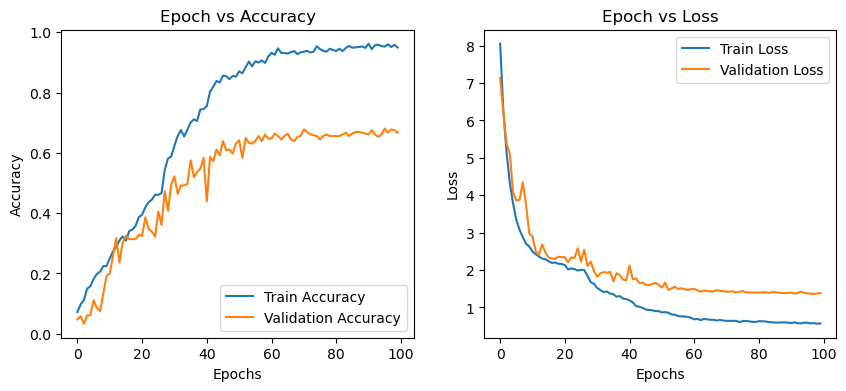

In [59]:
plt.rcParams["figure.figsize"] = (10, 4)

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

In [60]:
import winsound
winsound.Beep(240,2000)